---
title: "Visualizing what convnets learn"
output: 
  html_notebook: 
    theme: cerulean
    highlight: textmate
---



***

This notebook contains the code samples found in Chapter 5, Section 4 of [Deep Learning with R](https://www.manning.com/books/deep-learning-with-r). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

***

It is often said that deep learning models are "black boxes", learning representations that are difficult to extract and present in a human-readable form. While this is partially true for certain types of deep learning models, it is definitely not true for convnets. The representations learned by convnets are highly amenable to visualization, in large part because they are _representations of visual concepts_. Since 2013, a wide array of techniques have been developed for visualizing and interpreting these representations. We won't survey all of them, but we will cover three of the most accessible and useful ones:

* Visualizing intermediate convnet outputs ("intermediate activations"). This is useful to understand how successive convnet layers transform their input, and to get a first idea of the meaning of individual convnet filters.
* Visualizing convnets filters. This is useful to understand precisely what visual pattern or concept each filter in a convnet is receptive to.
* Visualizing heatmaps of class activation in an image. This is useful to understand which part of an image where identified as belonging to a given class, and thus allows to localize objects in images.

For the first method -- activation visualization -- we will use the small convnet that we trained from scratch on the cat vs. dog classification problem two sections ago. For the next two methods, we will use the VGG16 model that we introduced in the previous section.

## Visualizing intermediate activations

Visualizing intermediate activations consists in displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its "activation", the output of the activation function). This gives a view into how an input is decomposed unto the different filters learned by the network. These feature maps we want to visualize have 3 dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel, as a 2D image. Let's start by loading the model that we saved in section 5.2:

In [1]:
install.packages('keras')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rappdirs’, ‘config’, ‘reticulate’, ‘tensorflow’, ‘tfruns’




In [2]:
system("ls -l /content/sample_data/", intern=T)

[1] "total 55504"                                                              
[2] "-rwxr-xr-x 1 root root     1697 Jan  1  2000 anscombe.json"               
[3] "-rw-r--r-- 1 root root   301141 Jan 13 16:38 california_housing_test.csv" 
[4] "-rw-r--r-- 1 root root  1706430 Jan 13 16:38 california_housing_train.csv"
[5] "-rw-r--r-- 1 root root 18289443 Jan 13 16:38 mnist_test.csv"              
[6] "-rw-r--r-- 1 root root 36523880 Jan 13 16:38 mnist_train_small.csv"       
[7] "-rwxr-xr-x 1 root root      930 Jan  1  2000 README.md"

In [3]:
library(keras)
download.file("http://www.sakurai.comp.ae.keio.ac.jp/classes/TopicsML/cats_and_dogs_small_2.h5", "cats_and_dogs_small_2.h5")
model <- load_model_hdf5("cats_and_dogs_small_2.h5")
summary(model)  # As a reminder.

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_4 (Conv2D)                   (None, 148, 148, 32)            896         
________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)      (None, 74, 74, 32)              0           
________________________________________________________________________________
conv2d_5 (Conv2D)                   (None, 72, 72, 64)              18496       
________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)      (None, 36, 36, 64)              0           
________________________________________________________________________________
conv2d_6 (Conv2D)                   (None, 34, 34, 128)             73856       
________________________________________________________________________________
max_pool

This will be the input image we will use -- a picture of a cat, not part of images that the network was trained on:

In [0]:
download.file("http://www.sakurai.comp.ae.keio.ac.jp/classes/TopicsML/trainsmall.zip", "train.zip")
unzip("train.zip")

In [5]:
original_dataset_dir <- "train"

base_dir <- "cats_and_dogs_small"
dir.create(base_dir)

train_dir <- file.path(base_dir, "train")
dir.create(train_dir)
validation_dir <- file.path(base_dir, "validation")
dir.create(validation_dir)
test_dir <- file.path(base_dir, "test")
dir.create(test_dir)

train_cats_dir <- file.path(train_dir, "cats")
dir.create(train_cats_dir)

train_dogs_dir <- file.path(train_dir, "dogs")
dir.create(train_dogs_dir)

validation_cats_dir <- file.path(validation_dir, "cats")
dir.create(validation_cats_dir)

validation_dogs_dir <- file.path(validation_dir, "dogs")
dir.create(validation_dogs_dir)

test_cats_dir <- file.path(test_dir, "cats")
dir.create(test_cats_dir)

test_dogs_dir <- file.path(test_dir, "dogs")
dir.create(test_dogs_dir)

fnames <- paste0("cat.", 1:1000, ".jpg")
file.copy(file.path(original_dataset_dir, fnames), 
          file.path(train_cats_dir)) 

fnames <- paste0("cat.", 1001:1500, ".jpg")
file.copy(file.path(original_dataset_dir, fnames), 
          file.path(validation_cats_dir))

fnames <- paste0("cat.", 1501:2000, ".jpg")
file.copy(file.path(original_dataset_dir, fnames),
          file.path(test_cats_dir))

fnames <- paste0("dog.", 1:1000, ".jpg")
file.copy(file.path(original_dataset_dir, fnames),
          file.path(train_dogs_dir))

fnames <- paste0("dog.", 1001:1500, ".jpg")
file.copy(file.path(original_dataset_dir, fnames),
          file.path(validation_dogs_dir)) 

fnames <- paste0("dog.", 1501:2000, ".jpg")
file.copy(file.path(original_dataset_dir, fnames),
          file.path(test_dogs_dir))

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [15] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [29] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [43] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [57] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [71] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [85] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [99] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [113] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [127] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [141] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [155] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [169] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [183] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [197] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [211] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [225] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [239] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [253] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [267] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [281] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [295] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [309] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [323] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [337] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [351] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [365] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [379] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [393] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [407] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [421] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [435] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [449] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [463] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [477] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [491] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [505] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [519] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [533] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [547] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [561] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [575] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [589] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [603] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [617] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [631] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [645] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [659] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [673] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [687] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [701] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [715] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [76] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [91] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[106] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[121] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[136] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[151] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[166] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[181] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[196] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[211] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[226] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[241] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[256] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[271] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[286] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[301] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[316] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[331] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[346] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[361] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[376] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[391] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[406] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[421] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[436] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[451] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[466] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[481] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[496] TRUE TRUE TRUE TRUE TRUE

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [76] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [91] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[106] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[121] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[136] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[151] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[166] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[181] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[196] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[211] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[226] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[241] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[256] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[271] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[286] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[301] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[316] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[331] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[346] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[361] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[376] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[391] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[406] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[421] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[436] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[451] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[466] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[481] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[496] TRUE TRUE TRUE TRUE TRUE

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [15] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [29] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [43] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [57] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [71] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [85] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [99] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [113] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [127] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [141] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [155] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [169] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [183] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [197] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [211] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [225] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [239] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [253] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [267] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [281] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [295] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [309] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [323] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [337] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [351] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [365] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [379] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [393] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [407] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [421] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [435] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [449] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [463] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [477] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [491] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [505] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [519] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [533] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [547] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [561] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [575] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [589] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [603] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [617] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [631] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [645] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [659] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [673] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [687] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [701] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [715] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [76] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [91] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[106] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[121] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[136] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[151] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[166] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[181] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[196] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[211] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[226] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[241] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[256] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[271] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[286] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[301] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[316] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[331] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[346] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[361] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[376] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[391] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[406] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[421] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[436] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[451] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[466] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[481] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[496] TRUE TRUE TRUE TRUE TRUE

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [76] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [91] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[106] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[121] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[136] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[151] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[166] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[181] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[196] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[211] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[226] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[241] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[256] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[271] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[286] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[301] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[316] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[331] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[346] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[361] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[376] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[391] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[406] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[421] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[436] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[451] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[466] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[481] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[496] TRUE TRUE TRUE TRUE TRUE

In [6]:
img_path <- "cats_and_dogs_small/test/cats/cat.1700.jpg"

# We preprocess the image into a 4D tensor
img <- image_load(img_path, target_size = c(150, 150))
img_tensor <- image_to_array(img)
img_tensor <- array_reshape(img_tensor, c(1, 150, 150, 3))

# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor <- img_tensor / 255

dim(img_tensor)

[1]   1 150 150   3

Let's display our picture:

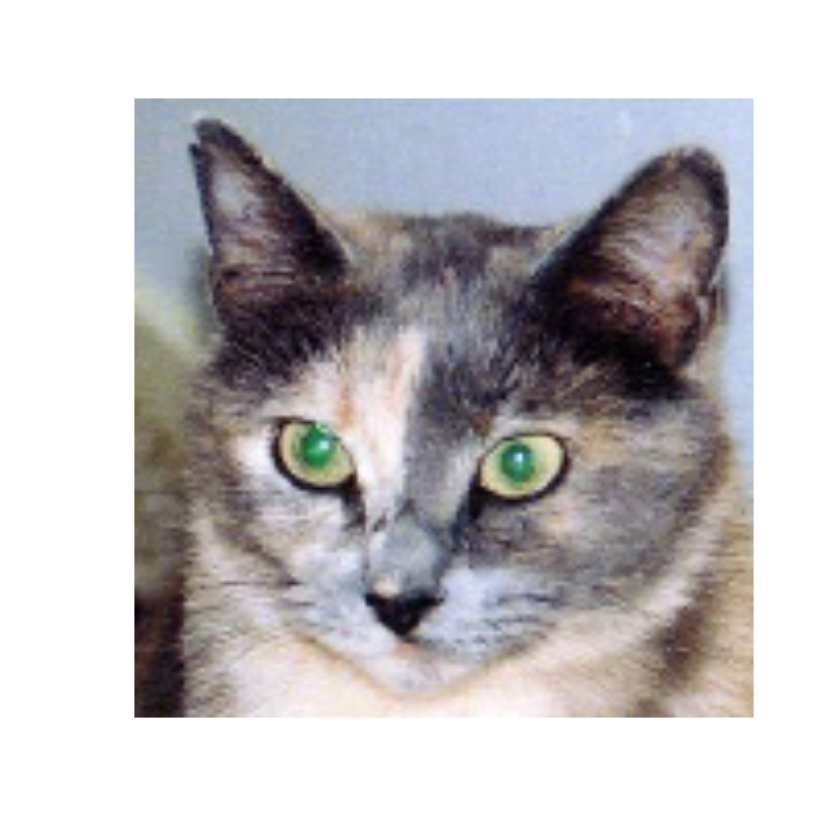

In [7]:
plot(as.raster(img_tensor[1,,,]))

In order to extract the feature maps you want to look at, you'll create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers. To do this, we will use the `keras_model()` function, which takes two arguments: an input tensor (or list of input tensors) and an output tensor (or list of output tensors). The resulting class is a Keras model, just like the ones created by the `keras_sequential_model()` function that you are familiar with, mapping the specified inputs to the specified outputs. What sets this type of model apart apart is that it allows for models with multiple outputs (unlike `keras_sequential_model()`). For more information about creating models with the `keras_model()` function, see section 7.1.

In [0]:
# Extracts the outputs of the top 8 layers:
layer_outputs <- lapply(model$layers[1:8], function(layer) layer$output)
# Creates a model that will return these outputs, given the model input:
activation_model <- keras_model(inputs = model$input, outputs = layer_outputs)

When fed an image input, this model returns the values of the layer activations in the original model. This is the first time you encounter a multi-output model in this book: until now the models you have seen only had exactly one input and one output. In the general case, a model could have any number of inputs and outputs. This one has one input and 8 outputs, one output per layer activation.

In [0]:
# Returns a list of five arrays: one array per layer activation
activations <- activation_model %>% predict(img_tensor)

For instance, this is the activation of the first convolution layer for our cat image input:

In [10]:
first_layer_activation <- activations[[1]]
dim(first_layer_activation)

[1]   1 148 148  32

It's a 148 x 148 feature map with 32 channels. Let's visualize some of them. First we define an R function 
that will plot a channel:

In [0]:
plot_channel <- function(channel) {
  rotate <- function(x) t(apply(x, 2, rev))
  image(rotate(channel), axes = FALSE, asp = 1, 
        col = terrain.colors(12))
}

Let's try visualizing the 5th channel:

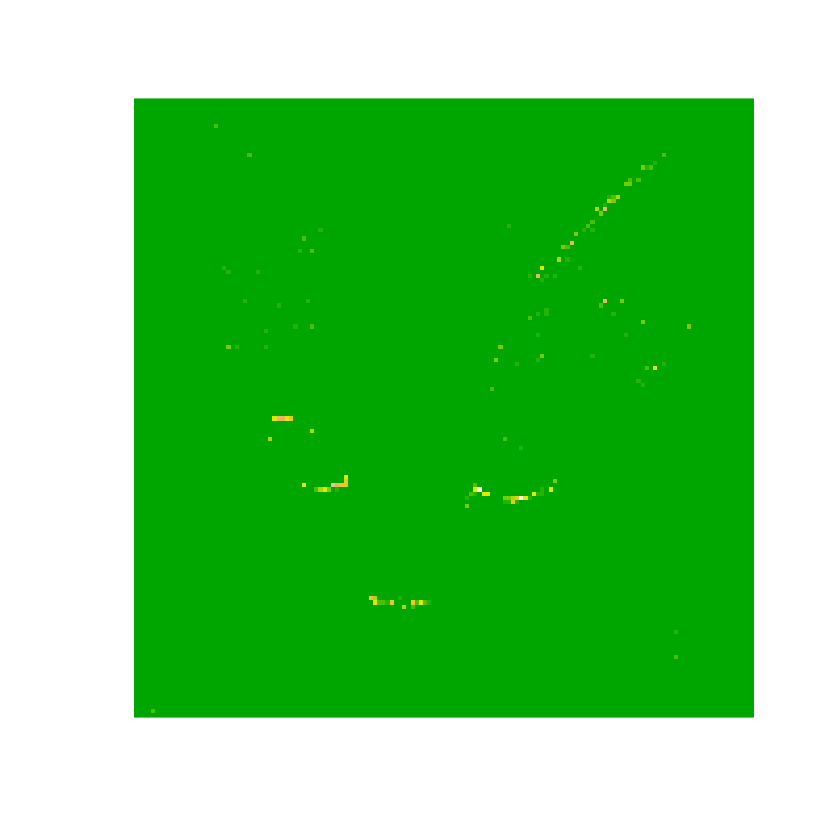

In [12]:
plot_channel(first_layer_activation[1,,,5])

This channel appears to encode some sort of edge detector. Let's try the 7th channel -- but note that your own channels may vary, since the  specific filters learned by convolution layers are not deterministic.

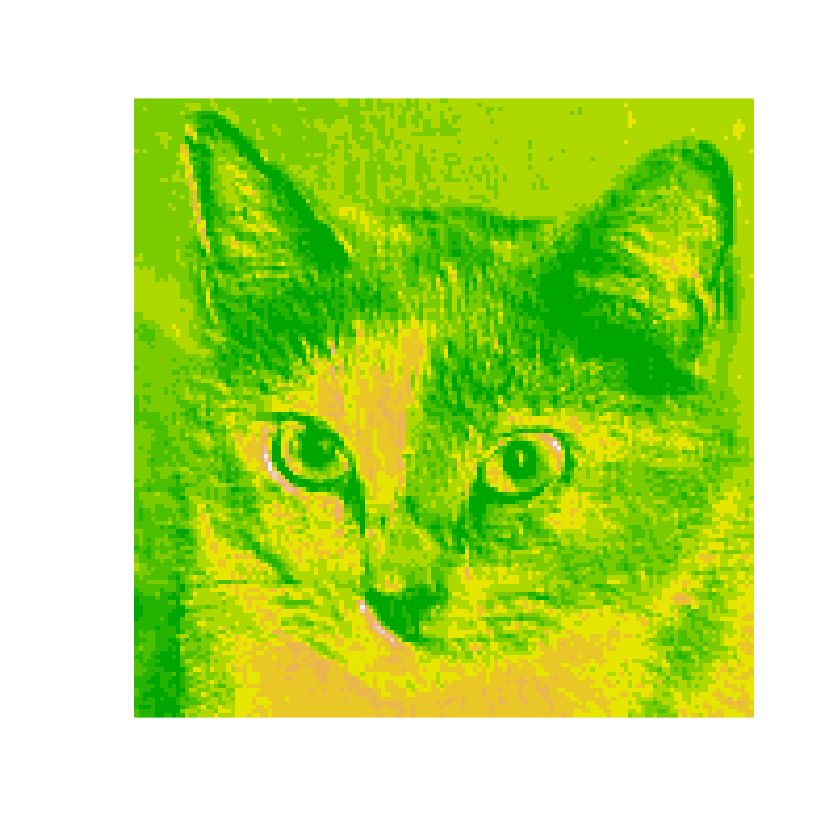

In [13]:
plot_channel(first_layer_activation[1,,,7])

This channel is subtly different, and unlike the 5th channel seems to be picking up the iris of the cat's eye. At this point, let's go and plot a complete visualization of all the activations in the network. We'll extract and plot every channel in each of our 8 activation maps, and we will stack the results in one big image tensor, with channels stacked side by side.

In [0]:
dir.create("cat_activations")
image_size <- 58
images_per_row <- 16

for (i in 1:8) {
  
  layer_activation <- activations[[i]]
  layer_name <- model$layers[[i]]$name
 
  n_features <- dim(layer_activation)[[4]]
  n_cols <- n_features %/% images_per_row
 
  png(paste0("cat_activations/", i, "_", layer_name, ".png"), 
      width = image_size * images_per_row, 
      height = image_size * n_cols)
  op <- par(mfrow = c(n_cols, images_per_row), mai = rep_len(0.02, 4))
  
  for (col in 0:(n_cols-1)) {
    for (row in 0:(images_per_row-1)) {
      channel_image <- layer_activation[1,,,(col*images_per_row) + row + 1]
      plot_channel(channel_image)
    }
  }
  
  par(op)
  dev.off()
}

In [15]:
system("ls /content/cat_activations", intern=T)

[1] "1_conv2d_4.png"        "2_max_pooling2d_4.png" "3_conv2d_5.png"       
[4] "4_max_pooling2d_5.png" "5_conv2d_6.png"        "6_max_pooling2d_6.png"
[7] "7_conv2d_7.png"        "8_max_pooling2d_7.png"

In [16]:
## https://stackoverflow.com/questions/16678934/r-cairo-installation-without-apt-get-sudo#25014476
system("apt-get install libcairo2-dev",intern=T)
install.packages("imager")
library(imager)

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following package was automatically installed and is no longer required:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [5] "  libnvidia-common-430"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
 [6] "Use 'apt autoremove' to remove it."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
 [7] "The following additional packages will be installed:"                                                                  

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bmp’, ‘tiff’, ‘png’, ‘jpeg’, ‘readbitmap’, ‘Cairo’, ‘downloader’, ‘igraph’


Loading required package: magrittr


Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following objects are masked from ‘package:stats’:

    convolve, spectrum


The following object is masked from ‘package:graphics’:

    frame


The following object is masked from ‘package:base’:

    save.image




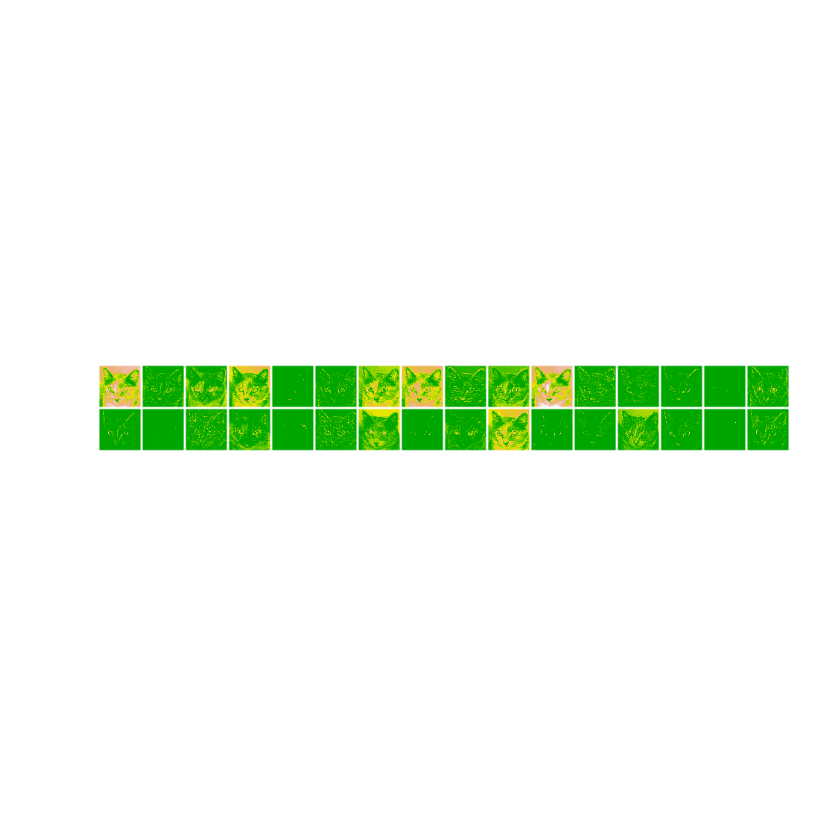

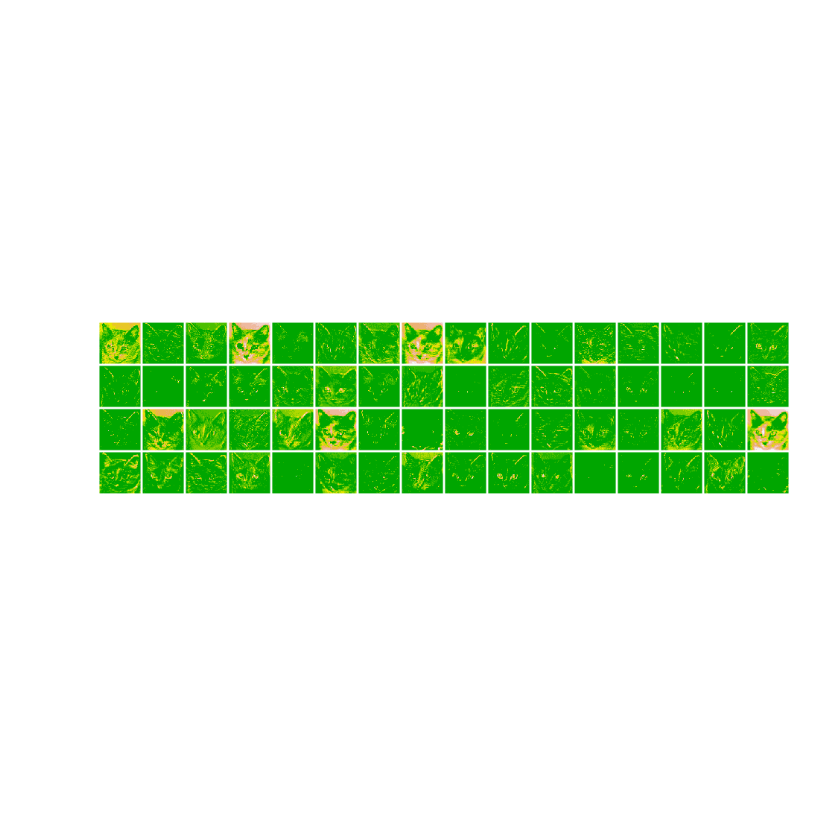

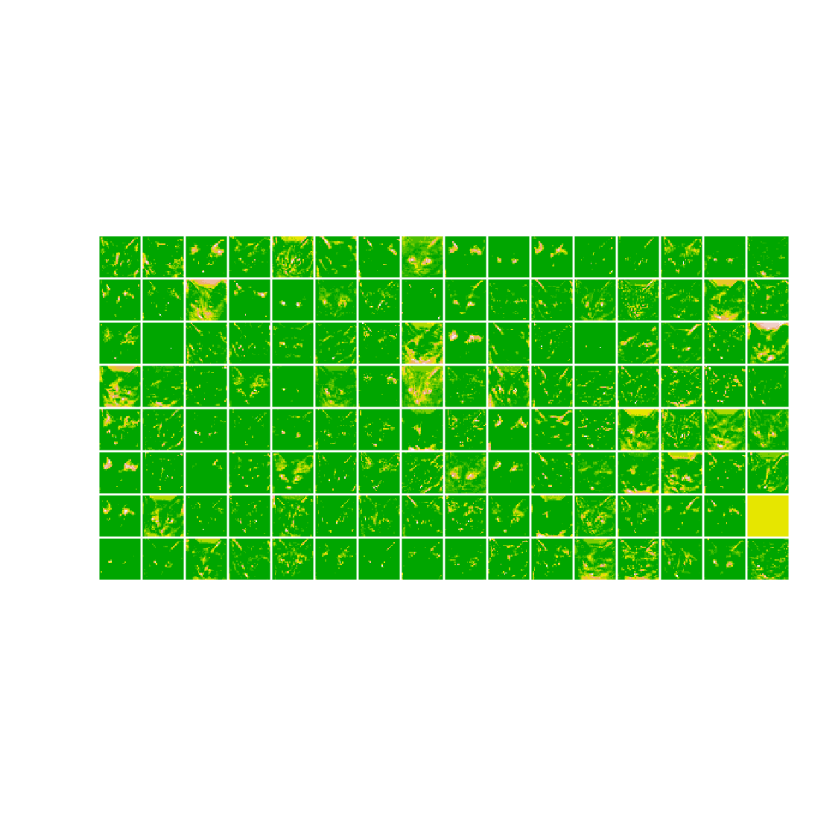

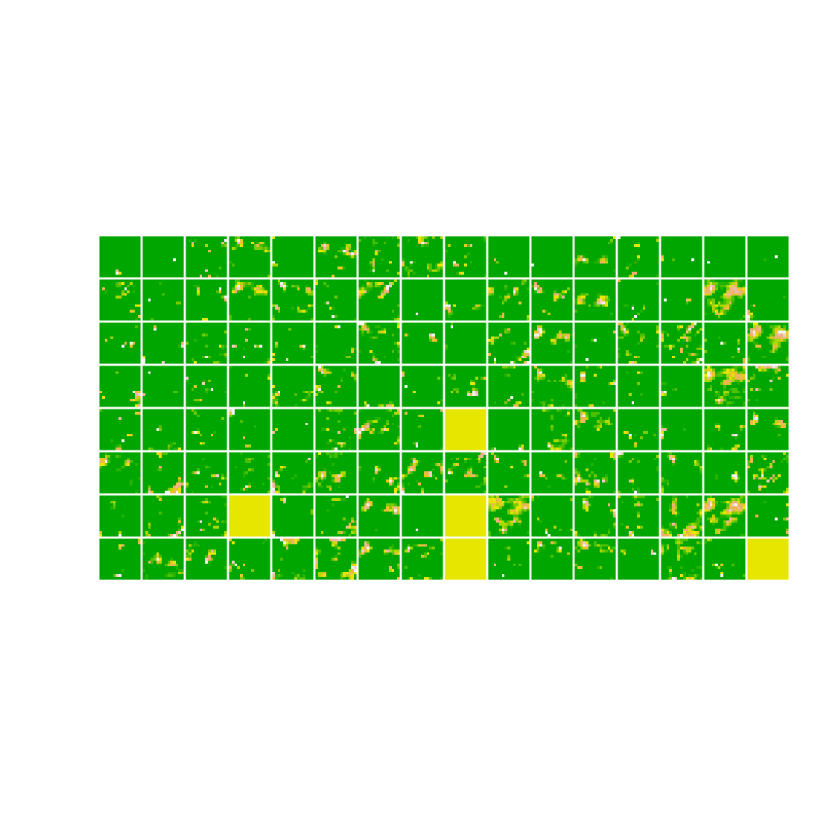

In [17]:
## http://htsuda.net/archives/1985
plot( as.raster( load.image("cat_activations/1_conv2d_4.png") ) )
plot( as.raster( load.image("cat_activations/3_conv2d_5.png") ) )
plot( as.raster( load.image("cat_activations/5_conv2d_6.png") ) )
plot( as.raster( load.image("cat_activations/7_conv2d_7.png") ) )



A few remarkable things to note here:

* The first layer acts as a collection of various edge detectors. At that stage, the activations are still retaining almost all of the information present in the initial picture.
* As we go higher-up, the activations become increasingly abstract and less visually interpretable. They start encoding higher-level concepts such as "cat ear" or "cat eye". Higher-up presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
* The sparsity of the activations is increasing with the depth of the layer: in the first layer, all filters are activated by the input image, but in the following layers some filters are blank. This means that the pattern encoded by the filter isn't found in the input image.

We have just evidenced a very important universal characteristic of the representations learned by deep neural networks: the features extracted by a layer get increasingly abstract with the depth of the layer. The activations of layers higher-up carry less and less information about the specific input being seen, and more and more information about the target (in our case, the class of the image: cat or dog). A deep neural network effectively acts as an __information distillation pipeline__, with raw data going in (in our case, RBG pictures), and getting repeatedly transformed so that irrelevant information gets filtered out (e.g. the specific visual appearance of the image) while useful information get magnified and refined (e.g. the class of the image).

This is analogous to the way humans and animals perceive the world: after observing a scene for a few seconds, a human can remember which abstract objects were present in it (e.g. bicycle, tree) but could not remember the specific appearance of these objects. In fact, if you tried to draw a generic bicycle from mind right now, chances are you could not get it even remotely right, even though you have seen thousands of bicycles in your lifetime. Try it right now: this effect is absolutely real. You brain has learned to completely abstract its visual input, to transform it into high-level visual concepts while completely filtering out irrelevant visual details, making it 
tremendously difficult to remember how things around us actually look.

## Visualizing convnet filters


Another easy thing to do to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to. This can be done with __gradient ascent in input space__: applying __gradient descent__ to the value of the input image of a convnet so as to maximize the response of a specific filter, starting from a blank input image. The resulting input image would be one that the chosen filter is maximally responsive to.

The process is simple: we will build a loss function that maximizes the value of a given filter in a given convolution layer, then we will use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. For instance, here's a loss for the activation of filter 0 in the layer "block3_conv1" of the VGG16 network, pre-trained on ImageNet:

In [0]:
library(keras)

model <- application_vgg16(
  weights = "imagenet", 
  include_top = FALSE
)

layer_name <- "block3_conv1"
filter_index <- 1

layer_output <- get_layer(model, layer_name)$output
loss <- k_mean(layer_output[,,,filter_index])

To implement gradient descent, we will need the gradient of this loss with respect to the model's input. To do this, we will use the `k_gradients` Keras backend function:

In [0]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads <- k_gradients(loss, model$input)[[1]] 

A non-obvious trick to use for the gradient descent process to go smoothly is to normalize the gradient tensor, by dividing it by its L2 norm (the square root of the average of the square of the values in the tensor). This ensures that the magnitude of the updates done to the input image is always within a same range.

In [0]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads <- grads / (k_sqrt(k_mean(k_square(grads))) + 1e-5)

Now you need a way to compute the value of the loss tensor and the gradient tensor, given an input image. You can define a Keras backend function to do this: `iterate` is a function that takes a tensor (as a list of tensors of size 1) and returns a list of two  tensors: the loss value and the gradient value.

In [0]:
iterate <- k_function(list(model$input), list(loss, grads))

# Let's test it
c(loss_value, grads_value) %<-%
    iterate(list(array(0, dim = c(1, 150, 150, 3))))

At this point we can define an R loop to do stochastic gradient descent:

In [0]:
# We start from a gray image with some noise
input_img_data <-
  array(runif(150 * 150 * 3), dim = c(1, 150, 150, 3)) * 20 + 128 

step <- 1  # this is the magnitude of each gradient update
for (i in 1:40) { 
  # Compute the loss value and gradient value
  c(loss_value, grads_value) %<-% iterate(list(input_img_data))
  # Here we adjust the input image in the direction that maximizes the loss
  input_img_data <- input_img_data + (grads_value * step)
}

The resulting image tensor is a floating-point tensor of shape `(1, 150, 150, 3)`, with values that may not be integers within [0, 255]. Hence you need to post-process this tensor to turn it into a displayable image. You do so with the following straightforward utility function.

In [0]:
deprocess_image <- function(x) {
 
  dms <- dim(x)
  
  # normalize tensor: center on 0., ensure std is 0.1
  x <- x - mean(x) 
  x <- x / (sd(x) + 1e-5)
  x <- x * 0.1 
  
  # clip to [0, 1]
  x <- x + 0.5 
  x <- pmax(0, pmin(x, 1))
  
  # Reshape to original image dimensions
  array(x, dim = dms)
}

Now you have all the pieces. Let's put them together into an R function that takes as input a layer name and a filter index, and  returns a valid image tensor representing the pattern that maximizes the activation of the specified filter.

In [0]:
generate_pattern <- function(layer_name, filter_index, size = 150) {
  
  # Build a loss function that maximizes the activation
  # of the nth filter of the layer considered.
  layer_output <- model$get_layer(layer_name)$output
  loss <- k_mean(layer_output[,,,filter_index]) 
  
  # Compute the gradient of the input picture wrt this loss
  grads <- k_gradients(loss, model$input)[[1]]
  
  # Normalization trick: we normalize the gradient
  grads <- grads / (k_sqrt(k_mean(k_square(grads))) + 1e-5)
  
  # This function returns the loss and grads given the input picture
  iterate <- k_function(list(model$input), list(loss, grads))
  
  # We start from a gray image with some noise
  input_img_data <- 
    array(runif(size * size * 3), dim = c(1, size, size, 3)) * 20 + 128
  
  # Run gradient ascent for 40 steps
  step <- 1
  for (i in 1:40) {
    c(loss_value, grads_value) %<-% iterate(list(input_img_data))
    input_img_data <- input_img_data + (grads_value * step) 
  }
  
  img <- input_img_data[1,,,]
  deprocess_image(img) 
}

Let's try this:


Attaching package: ‘grid’


The following object is masked from ‘package:imager’:

    depth




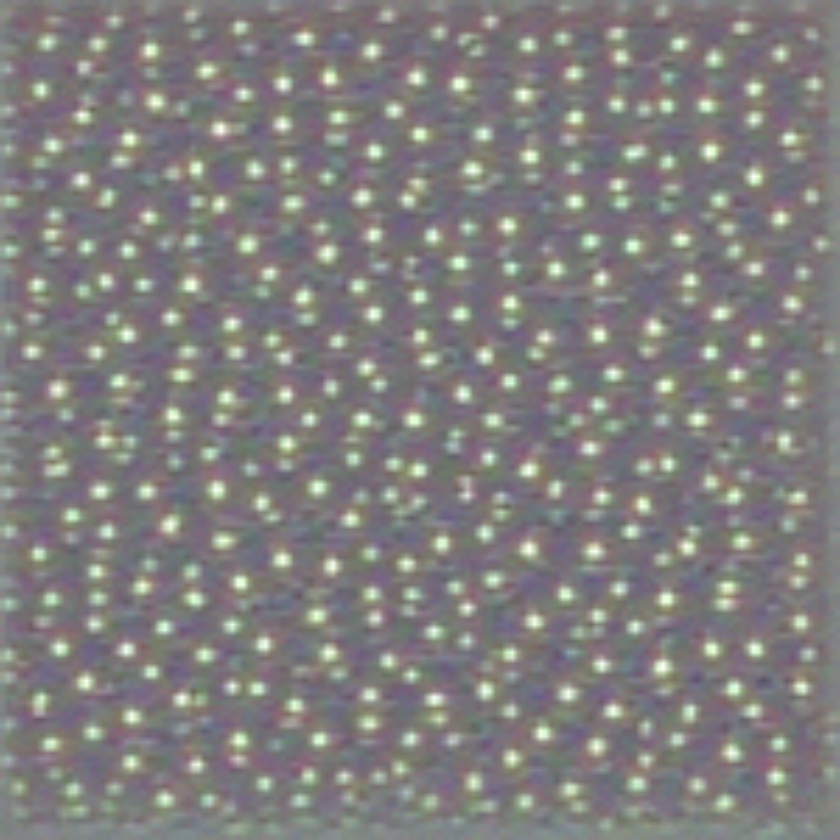

In [25]:
library(grid)
grid.raster(generate_pattern("block3_conv1", 1))

![](images/polka_dots-r.png)

<br/>

It seems that filter 1 in layer `block3_conv1` is responsive to a polka dot pattern.

Now the fun part: we can start visualising every single filter in every layer. For simplicity, we will only look at the first 64 filters in 
each layer, and will only look at the first layer of each convolution block (block1_conv1, block2_conv1, block3_conv1, block4_conv1, 
block5_conv1). We will arrange the outputs on a 8x8 grid of filter patterns.

In [26]:
install.packages("gridExtra")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [0]:
library(grid)
library(gridExtra)
dir.create("vgg_filters")
for (layer_name in c("block1_conv1", "block2_conv1", 
                     "block3_conv1", "block4_conv1")) {
  size <- 140
  
  png(paste0("vgg_filters/", layer_name, ".png"),
      width = 8 * size, height = 8 * size)
  
  grobs <- list()
  for (i in 0:7) {
    for (j in 0:7) {
      pattern <- generate_pattern(layer_name, i + (j*8) + 1, size = size)
      grob <- rasterGrob(pattern, 
                         width = unit(0.9, "npc"), 
                         height = unit(0.9, "npc"))
      grobs[[length(grobs)+1]] <- grob
    }  
  }
  
  grid.arrange(grobs = grobs, ncol = 8)
  dev.off()
}

In [28]:
plot( as.raster( load.image("vgg_filters/block1_conv1.png") ) )
plot( as.raster( load.image("vgg_filters/block2_conv1.png") ) )
plot( as.raster( load.image("vgg_filters/block3_conv1.png") ) )
plot( as.raster( load.image("vgg_filters/block4_conv1.png") ) )

Output hidden; open in https://colab.research.google.com to view.


These filter visualizations tell you a lot about how convnet layers see the world: each layer in a convnet learns a collection of filters such that their inputs can be expressed as a combination of the filters. This is similar to how the Fourier transform decomposes signals onto a bank of cosine functions. The filters in these convnet filter banks get increasingly complex and refined as you go higher in the model:

* The filters from the first layer in the model (`block1_conv1`) encode simple directional edges and colors (or colored edges in some cases).
* The filters from `block2_conv1` encode simple textures made from combinations of edges and colors.
* The filters in higher layers begin to resemble textures found in natural images: feathers, eyes, leaves, and so on.

## Visualizing heatmaps of class activation

We'll introduce one more visualization technique: one that is useful for understanding which parts of a given image led a convnet to its final classification decision. This is helpful for debugging the decision process of a convnet, particularly in the case of a classification mistake. It also allows you to locate specific objects in an image.

This general category of techniques is called _class activation map_ (CAM) visualization, and it consists of producing heatmaps of class activation over input images. A class-activation heatmap is a 2D grid of scores associated with a specific output class, computed for every location in any input image, indicating how important each location is with respect to the class under consideration. For instance, given an image fed into a cat-versus-dog convnet, CAM visualization allows you to generate a heatmap for the class "cat," indicating how cat-like different parts of the image are, and also a heatmap for the class "dog," indicating how dog-like parts of the image are.

The specific implementation you'll use is the one described in "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization."footnote:[Ramprasaath R. Selvaraju et al., Cornell University Library, March 21, 2017, https://arxiv.org/abs/1610.02391.]. It's very simple: it consists of taking the output feature map of a convolution layer, given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the channel. Intuitively, one way to understand this trick is that you're weighting a spatial map of "how intensely the input image activates different channels" by "how important each channel is with regard to the class," resulting in a spatial map of "how intensely the input image activates the class."

We'll demonstrate this technique using the pretrained VGG16 network again.

In [0]:
# Clear out the session
k_clear_session()

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model <- application_vgg16(weights = "imagenet")

Let's consider the following image of two African elephants, possible a mother and its cub, strolling in the savanna (under a Creative 
Commons license):

![elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)

Let's convert this image into something the VGG16 model can read: the model was trained on images of size 224 × 244, preprocessed according to a few rules that are packaged in the utility function `imagenet_preprocess_input()`. So you need to load the image, resize it to 224 × 224, convert it to an array, and apply these preprocessing rules.

In [0]:
download.file("http://www.sakurai.comp.ae.keio.ac.jp/classes/TopicsML/creative_commons_elephant.jpg", "creative_commons_elephant.jpg")

In [31]:
system("ls -l", intern=T)

[1] "total 115756"                                                              
[2] "drwxr-xr-x 2 root root     4096 Jan 30 02:50 cat_activations"              
[3] "drwxr-xr-x 5 root root     4096 Jan 30 02:48 cats_and_dogs_small"          
[4] "-rw-r--r-- 1 root root 27666648 Jan 30 02:48 cats_and_dogs_small_2.h5"     
[5] "-rw-r--r-- 1 root root   190269 Jan 30 03:05 creative_commons_elephant.jpg"
[6] "drwxr-xr-x 1 root root     4096 Jan 13 16:38 sample_data"                  
[7] "drwxr-xr-x 2 root root   135168 Jan 30 02:48 train"                        
[8] "-rw-r--r-- 1 root root 90514619 Jan 30 02:48 train.zip"                    
[9] "drwxr-xr-x 2 root root     4096 Jan 30 03:03 vgg_filters"

In [0]:
# The local path to our target image
img_path <- "creative_commons_elephant.jpg"
  
# Start witih image of size 224 × 224
img <- image_load(img_path, target_size = c(224, 224)) %>% 
  # Array of shape (224, 224, 3)
  image_to_array() %>% 
  # Adds a dimension to transform the array into a batch of size (1, 224, 224, 3)
  array_reshape(dim = c(1, 224, 224, 3)) %>% 
  # Preprocesses the batch (this does channel-wise color normalization)
  imagenet_preprocess_input()

You can now run the pretrained network on the image and decode its prediction vector back to a human-readable format:

In [33]:
preds <- model %>% predict(img)
imagenet_decode_predictions(preds, top = 3)[[1]]

class_name class_description score      
1 n02504458  African_elephant  0.909421444
2 n01871265  tusker            0.086182430
3 n02504013  Indian_elephant   0.004354568

The top-3 classes predicted for this image are:

* African elephant (with 90.9% probability)
* Tusker (with 8.6% probability)
* Indian elephant (with 0.4% probability)

Thus our network has recognized our image as containing an undetermined quantity of African elephants. The entry in the prediction vector 
that was maximally activated is the one corresponding to the "African elephant" class, at index 387:

In [34]:
which.max(preds[1,])

[1] 387

To visualize which parts of our image were the most "African elephant"-like, let's set up the Grad-CAM process:

In [0]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output <- model$output[, 387]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer <- model %>% get_layer("block5_conv3")

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads <- k_gradients(african_elephant_output, last_conv_layer$output)[[1]]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads <- k_mean(grads, axis = c(1, 2, 3))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate <- k_function(list(model$input),
                      list(pooled_grads, last_conv_layer$output[1,,,])) 

# These are the values of these two quantities, as arrays,
# given our sample image of two elephants
c(pooled_grads_value, conv_layer_output_value) %<-% iterate(list(img))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for (i in 1:512) {
  conv_layer_output_value[,,i] <- 
    conv_layer_output_value[,,i] * pooled_grads_value[[i]] 
}

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap <- apply(conv_layer_output_value, c(1,2), mean)

For visualization purposes, you'll also normalize the heatmap between 0 and 1. The result is shown in figure 5.35.

In [0]:
heatmap <- pmax(heatmap, 0) 
heatmap <- heatmap / max(heatmap)

write_heatmap <- function(heatmap, filename, width = 224, height = 224,
                          bg = "white", col = terrain.colors(12)) {
  png(filename, width = width, height = height, bg = bg)
  op = par(mar = c(0,0,0,0))
  on.exit({par(op); dev.off()}, add = TRUE)
  rotate <- function(x) t(apply(x, 2, rev))
  image(rotate(heatmap), axes = FALSE, asp = 1, col = col)
}

write_heatmap(heatmap, "elephant_heatmap.png") 

![](images/elephant_heatmap.png)

<br/>

Finally, we will use the *magick* package to generate an image that superimposes the original image with the heatmap we just obtained:

In [37]:
## magick packages could not be installe. Reason is that we need to build from source for Ubuntu.
## for that,
## https://cran.r-project.org/web/packages/magick/vignettes/intro.html#installing_magick
## says we need to sudo apt-get install libmagick++-dev before installation from source.
## but this fails too. Error message says 404 for some modules.
## and in fact, system("R CMD build magick", intern=T) did not work.

install.packages("magick")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("magick"):
“installation of package ‘magick’ had non-zero exit status”


In [38]:
install.packages("viridis")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [39]:
system("sudo apt-get install libmagick++-dev",intern=T)

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
  [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
  [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
  [4] "The following package was automatically installed and is no longer required:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
  [5] "  libnvidia-common-430"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
  [6] "Use 'sudo apt autoremove' to remove it."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
  [7] "The following additional packages will be installed:"                                                            

In [40]:
system("cp /tmp/Rtmp4IkY1j/downloaded_packages/magick_2.1.tar.gz /content",intern=T)

Warning message in system("cp /tmp/Rtmp4IkY1j/downloaded_packages/magick_2.1.tar.gz /content", :
“running command 'cp /tmp/Rtmp4IkY1j/downloaded_packages/magick_2.1.tar.gz /content' had status 1”


character(0)
attr(,"status")
[1] 1
attr(,"errmsg")
[1] "Resource temporarily unavailable"

In [41]:
system("tar xzf magick_2.1.tar.gz", intern=T)

Warning message in system("tar xzf magick_2.1.tar.gz", intern = T):
“running command 'tar xzf magick_2.1.tar.gz' had status 2”


character(0)
attr(,"status")
[1] 2
attr(,"errmsg")
[1] "Resource temporarily unavailable"

In [42]:
system("R CMD build magick", intern=T)

Warning message in system("R CMD build magick", intern = T):
“running command 'R CMD build magick' had status 1”


[1] " ERROR"                              "cannot change to directory ‘magick’"
attr(,"status")
[1] 1
attr(,"errmsg")
[1] "Resource temporarily unavailable"

In [43]:
library(magick) 
library(viridis) 

# Read the original elephant image and it's geometry
image <- image_read(img_path)
info <- image_info(image) 
geometry <- sprintf("%dx%d!", info$width, info$height) 

# Create a blended / transparent version of the heatmap image
pal <- col2rgb(viridis(20), alpha = TRUE) 
alpha <- floor(seq(0, 255, length = ncol(pal))) 
pal_col <- rgb(t(pal), alpha = alpha, maxColorValue = 255)
write_heatmap(heatmap, "elephant_overlay.png", 
              width = 14, height = 14, bg = NA, col = pal_col) 

# Overlay the heatmap
image_read("elephant_overlay.png") %>% 
  image_resize(geometry, filter = "quadratic") %>% 
  image_composite(image, operator = "blend", compose_args = "20") %>%
  plot() 

ERROR: ignored

This visualisation technique answers two important questions:

* Why did the network think this image contained an African elephant?
* Where is the African elephant located in the picture?

In particular, it is interesting to note that the ears of the elephant cub are strongly activated: this is probably how the network can 
tell the difference between African and Indian elephants.